In [1]:
import os
import torch
import torchvision
from torch import nn
from torch.nn import functional as F
from torch.utils.data import TensorDataset, DataLoader
from d2l import torch as d2l
from pathlib import Path
from torchmetrics.classification import BinaryF1Score
import sys
import nibabel as nib
import numpy as np
import gc

In [2]:
class convBlock(nn.Module):
    def __init__(self, inChannels, outChannels, batchNorm, strides) -> None:
        super().__init__()

        self.conv1 = nn.Conv2d(inChannels, outChannels, kernel_size=3, padding=1, stride=strides)
        self.conv2 = nn.Conv2d(outChannels, outChannels, kernel_size=3, padding=1)

        nn.init.uniform_(self.conv1.weight)
        nn.init.uniform_(self.conv2.weight)

        if(batchNorm):
            self.bn1 = nn.BatchNorm2d(outChannels)
        else:
            self.bn1 = False

    def forward(self, X):
        Y = self.conv1(X)

        if(self.bn1):
            Y = self.bn1(Y)

        Y = F.relu(Y)

        return torch.Tensor(F.relu(self.conv2(Y)))

In [3]:
class EncoderBlock(nn.Module):
    def __init__(self, inChannels, outChannels, strides) -> None:
        super().__init__()

        self.conv = convBlock(inChannels, outChannels, True, strides)
        self.pool = nn.MaxPool2d(2, stride=strides)

    def forward(self, X):

        Y = self.conv.forward(X)

        #return torch.Tensor(self.pool(Y)), Y
        return self.pool(Y)

In [4]:
class DecoderBlock(nn.Module):
    def __init__(self, inChannels, outChannels, strides) -> None:
        super().__init__()

        self.convTrans = nn.ConvTranspose2d(inChannels, outChannels, 2, stride=strides, padding=1)
        self.conv = convBlock(outChannels, outChannels, True, strides)

    def forward(self, X, skipFeatures):
        Y = self.convTrans(X)
        Y = torch.cat(X, skipFeatures)
        return self.conv(Y)

In [5]:
def evaluate_accuracy(net, testIter, device=None):
    if isinstance(net, nn.Module):
        net.eval()
        if not device:
            device = next(iter(net.parameters())).device

    metric = d2l.Accumulator(2)

    with torch.no_grad():
        for X, y in testIter:
            X = X.to(device)
            y = y.to(device)

            metric.add(d2l.accuracy(torch.round(torch.clamp(net(X), min=0, max=1)), y), y.numel())

    return metric[0] / metric[1]

In [11]:
def train(net: nn.Sequential, trainIter, testIter, numEpochs, learnRate, batchSize, device: torch.device, lossFunc = nn.BCEWithLogitsLoss()):
    print(f"Training on {device}")
    
    net.to(device)
    optimizer = torch.optim.SGD(net.parameters(), lr=learnRate)
    numBatches = len(trainIter)

    anim = d2l.Animator(xlabel="Epoch", xlim=[0, numEpochs - 1], legend=["Loss", "Train Accuracy", "Test Accuracy"])

    for epoch in range(numEpochs):
        net.train()
        metric = d2l.Accumulator(2)

        for i, (X, y) in enumerate(trainIter):
            optimizer.zero_grad()
            X, y = X.to(device), y.to(device)

            yhat = net(X)

            prediction = torch.round(torch.clamp(yhat, min=0, max=1)).to(device)

            l = lossFunc(yhat.squeeze(1), y)
            l.backward()
            optimizer.step()

            #print(f"{yhat} {prediction} {y} {l}")

            metric.add(l, d2l.accuracy(prediction, y) / batchSize)

        anim.add(epoch, (metric[0] / (numBatches * 100), (metric[1] / (numBatches * batchSize)), evaluate_accuracy(net, testIter, device)))
        #print(f"Loss: {sumLoss / numBatches} Accuracy: {sumAcc / (numBatches * batchSize)}")

KeyboardInterrupt: 

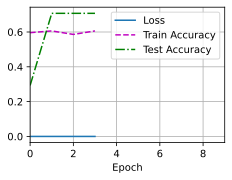

In [12]:
gc.collect()

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
#device = torch.device("cpu")

batchSize = 2
learnRate = 0.00001
epochs = 5
testSetSize = 1

block1 = EncoderBlock(1, 64, 1)
block2 = EncoderBlock(64, 128, 1)
block3 = EncoderBlock(128, 256, 1)
block4 = EncoderBlock(256, 512, 1)
block5 = EncoderBlock(512, 1024, 1)

net = nn.Sequential(block1, block2, block3, nn.AdaptiveAvgPool2d((1, 1)), nn.Flatten(), nn.Linear(256, 1))
#print(summary(net, (1, 512, 512)))

print("Intialized model")



xDir = "Dataset/Volumes/"
yDir = "Dataset/Segmentations/"
numFiles = len([name for name in os.listdir(xDir) if os.path.isfile(os.path.join(xDir, name))])

xData = []
yData = []

xTestData = []
yTestData = []

for i, name in enumerate(os.listdir(xDir)):
    if name[0] == '.':
        continue

    ctScan = nib.load(xDir + name)
    data = ctScan.get_fdata()

    for plane in range(data.shape[2]):
        p = data[:,:,plane].astype(np.int16)

        if numFiles - i > testSetSize:
            xData.append(p)
        else:
            xTestData.append(p)

for i, name in enumerate(os.listdir(yDir)):
    if name[0] == '.':
        continue

    segmentation = nib.load(yDir + name)
    data = segmentation.get_fdata()

    for plane in range(data.shape[2]):
        p = data[:,:,plane].astype(np.int16)

        if(numFiles - i > testSetSize):
            yData.append(min(np.amax(p), 1))
        else:
            yTestData.append(min(np.amax(p), 1))

tensorX = torch.Tensor(np.array(xData)).unsqueeze(1)
tensorY = torch.Tensor(np.array(yData))

tensorTestX = torch.Tensor(np.array(xData)).unsqueeze(1)
tensorTestY = torch.Tensor(np.array(yData))

print(tensorX.shape)
print(tensorY.shape)

print("Finished loading data")

dataset = TensorDataset(tensorX, tensorY)
trainIter = DataLoader(dataset, batch_size=batchSize, shuffle=True)

testDataset = TensorDataset(tensorTestX, tensorTestY)
testIter = DataLoader(testDataset, batch_size=1, shuffle=False)

train(net, trainIter, testIter, epochs, learnRate, batchSize, device)